In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '' 
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'

In [2]:
import cv2
from ocr.ru import LangWrapper, Ru, Eu

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.13) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [7]:
ru_rec = LangWrapper(Ru())
eu_rec = LangWrapper(Eu())

Downloaded model path: /home/worker/workspace/tdbm-secure-cctv/pybooks/ocr/./data/./models/TextDetector/Eu/anpr_ocr_eu_2022_03_28_pytorch_lightning.ckpt


anpr_ocr_eu_2022_03_28_pytorch_lightning.ckpt: 13.9MB [00:03, 3.95MB/s]                                                                                       


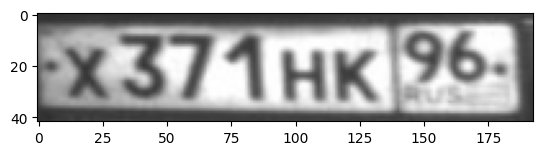

In [177]:
import cv2
import matplotlib.pylab as plt
import numpy as np
from pathlib import Path

# image = cv2.imread('', cv2.IMREAD_GRAYSCALE)
# image = np.stack([image,image,image], axis=-1)
filenames = [str(s) for s in Path('/mnt/nvme/WORKERS/USERS/elisey_norsi_worker/workspace/tdbm-secure-cctv/car_plate_recognize/nomeroff-net/data/dataset/TextDetector/ocr_example/test/img/').glob('*')]
image = cv2.imread(str(filenames[0]))
plt.imshow(image)

In [9]:
res = ru_rec.predict_images([image])
res

['X371HK96']

In [10]:
res = eu_rec.predict_images([image])
res

['X371HK6']

In [11]:
preds = ru_rec.predict_filenames(filenames)

In [13]:
preds

['X371HK96', 'A2956669', 'T251KC77', 'A40013BM']

In [18]:
%%timeit

preds = eu_rec.predict_filenames(filenames[:1])
# preds

8.45 ms ± 82.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [223]:
import cv2
import base64
import numpy as np
import requests
import io
import json

def resize_image(image, desired_width):
    current_width = image.shape[1]
    scale_percent = desired_width / current_width
    width = int(image.shape[1] * scale_percent)
    height = int(image.shape[0] * scale_percent)
    resized = cv2.resize(image, (width, height), interpolation=cv2.INTER_AREA)
    return resized

def compress_image(image, grayscale=True, desired_width=480):
    if grayscale:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image = resize_image(image, desired_width)
    return image


def image_from_bytes(byte_im):
    nparr = np.frombuffer(byte_im, np.uint8)
    img_np = cv2.imdecode(nparr, cv2.IMREAD_GRAYSCALE)
    return img_np

def image_from_base64(string: str):
    bytes_ = base64.b64decode(string.encode("utf-8"))
    return image_from_bytes(bytes_)


def image_to_jpeg_nparray(image, quality=[int(cv2.IMWRITE_JPEG_QUALITY), 95]):
    is_success, im_buf_arr = cv2.imencode(".jpg", image, quality)
    return im_buf_arr


def image_to_jpeg_bytes(image, quality=[int(cv2.IMWRITE_JPEG_QUALITY), 95]):
    buf = image_to_jpeg_nparray(image, quality)
    byte_im = buf.tobytes()
    return byte_im

def optimize_to_send(image, target_size=None):
    reduced = image.copy()
    if target_size is not None:
        reduced = compress_image(reduced, desired_width=target_size)
    byte_im = image_to_jpeg_bytes(reduced)
    # encode image
    img_enc = base64.b64encode(byte_im).decode("utf-8")
    img_dump = {"img_base64": img_enc}
#     img_dump = json.dumps({"img_base64": img_enc})
    return img_dump

def optimize_to_send(image, target_size=None):
    reduced = image.copy()
    if target_size is not None:
        reduced = compress_image(reduced, desired_width=target_size)
    byte_im = image_to_jpeg_bytes(reduced)
    # encode image
    img_enc = base64.b64encode(byte_im)#.decode("utf-8")
    img_dump = {"img_base64": img_enc}
#     img_dump = json.dumps({"img_base64": img_enc})
    return img_dump

In [179]:
import requests

def lp_result_from_response(response):
    dct = json.loads(response.content.decode('utf-8'))
    assert dct.get('success')
    assert dct.get('predictions') is not None
    
    return dct['predictions']['license_plate']

def df_results_from_response(response):
    dct = json.loads(response.content.decode('utf-8'))
    assert dct.get('success')
    assert dct.get('predictions') is not None
    
    locations = []
    embeddings = []
    for rec in dct['predictions']:
        locations.append(rec['location'])
        embeddings.append(rec['embedding'])
    return locations, embeddings

def ef_results_from_response(response):
    dct = json.loads(response.content.decode('utf-8'))
    assert dct.get('success')
    assert dct.get('predictions') is not None
    return dct['predictions']['embedding']

def process_lp_request(image):
    send_ = optimize_to_send(image)
    response = requests.post('http://ml.n19:11080/license_plate', data=send_)
    return lp_result_from_response(response)

def process_det_face_request(image):
    send_ = optimize_to_send(image, 480)
    response = requests.post('http://ml.n19:11080/detect_face', data=send_)
    locations, embeddings = df_results_from_response(response)
    return send_['img_base64'], locations, embeddings

def process_rec_face_request(image):
    send_ = optimize_to_send(image, 112)
    response = requests.post('http://ml.n19:11080/embed_face', data=send_)
    embeddings = ef_results_from_response(response)
    return embeddings

In [224]:
res = optimize_to_send(image)['img_base64']

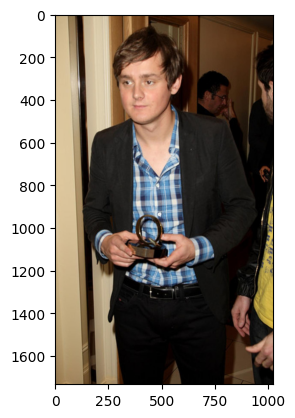

In [186]:
face_image = cv2.cvtColor(cv2.imread('16_Award_Ceremony_Awards_Ceremony_16_119.jpg', cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
plt.imshow(face_image)

In [187]:
# %%timeit
res, lloc, lemb = process_det_face_request(face_image)

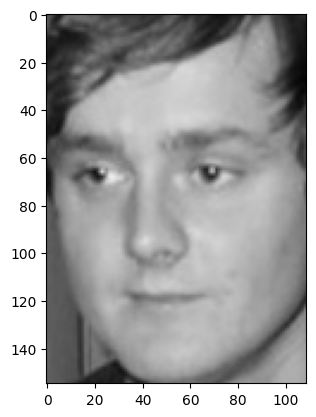

In [189]:
loc = lloc[0]
extr_face = image_from_base64(res)[loc[1]:loc[1]+loc[3], loc[0]:loc[0]+loc[2]]
extr_face = np.stack([extr_face,extr_face,extr_face], axis=-1)
plt.imshow(extr_face)

In [114]:
# %%timeit

remb = process_rec_face_request(extr_face)

In [116]:
from sklearn.metrics import pairwise_distances

In [117]:
rvec = np.random.uniform(0,1, size=512)

In [118]:
max(remb)

0.5901166200637817

In [119]:
pairwise_distances([remb, lemb[0], rvec])

array([[ 0.        ,  0.54387135, 14.39504438],
       [ 0.54387135,  0.        , 14.3387879 ],
       [14.39504438, 14.3387879 ,  0.        ]])

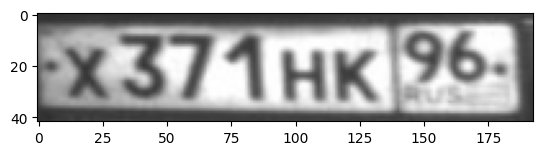

In [120]:
plt.imshow(image)

In [121]:
process_request(image)

'X371HK6'

In [19]:
%%timeit
process_request(image)

120 ms ± 21.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [123]:
pip install psycopg2-binary

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [19]:
import numpy as np

In [20]:
vec = np.random.uniform(0,1, size=512)
vec.shape

(512,)

In [222]:
optimize_to_send(extr_face)['img_base64'].encode('utf-8').decode('utf-8')

'/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAIBAQEBAQIBAQECAgICAgQDAgICAgUEBAMEBgUGBgYFBgYGBwkIBgcJBwYGCAsICQoKCgoKBggLDAsKDAkKCgr/2wBDAQICAgICAgUDAwUKBwYHCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgr/wAARCACbAG0DASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD87/FM/gi2+NcHif4hLI3hzTbjbaQpFhH29CfWvW9E/aW07Xb2R/DdvY3NiuPs8bzBGQegBIr5A1LxV4n8Y2R8PPqslxEsodo35APtUmgeAPEEEySWYkLL91FzjHrQB9i/8Jh4d8cxfYX0OCxe5JE8jgEJ9CPWsmL4c+FL2G4

In [228]:
import psycopg2
import base64

conn = psycopg2.connect(dbname='tdbm', user='web1', 
                        password='123456', host='ml.n19')

# binary = psycopg2.Binary('hello')
cursor = conn.cursor()
result = cursor.execute("insert into events (user_id, embedding, img_region) values (gen_random_uuid(), '[1,2,3]', %s);",(optimize_to_send(image)['img_base64'],))
result = cursor.execute("insert into events (user_id, plate, img_region) values (gen_random_uuid(), 'У717КК77', %s);",(optimize_to_send(extr_face)['img_base64'],))
result = cursor.execute("insert into events (user_id, plate, img_region) values (gen_random_uuid(), 'У717КК77', %s);",(optimize_to_send(extr_face)['img_base64'],))
result = cursor.execute("insert into events (user_id, plate, img_region) values (NULL, NULL, %s);",(optimize_to_send(extr_face)['img_base64'],))
conn.commit()
# result = cursor.execute(f"insert into faces (name, embedding, active) values ( 'gorai', '{vec.tolist()}', TRUE);")
# conn.commit()

In [201]:
pgdb = psycopg2.connect(dbname='tdbm', user='web1', 
                        password='123456', host='ml.n19')

# cursor = pgdb.cursor()
# cursor.execute("select (uid, name, plate) from plates where (plate='У717КК77')")
# result = cursor.fetchone()

In [229]:
rvec = np.random.uniform(0,1, size=512)

In [234]:
from sklearn.metrics import euclidean_distances
euclidean_distances([rvec],[rvec])[0][0]

4.76837158203125e-07

In [236]:
cursor = pgdb.cursor()
cursor.execute(f"SELECT (uid, name, embedding) FROM faces ORDER BY embedding <-> '{rvec.tolist()}' LIMIT 1;")
result = cursor.fetchone()

In [245]:
rr = result[0].replace('(','').replace(')','')
a, b = rr.split(',')[:2]

In [243]:
a,b

('511a3352-6186-4b63-809e-f6b62e63ff56', 'gorai')

In [246]:
eval(rr.split('"')[1])

[0.3400000035762787,
 0.9319999814033508,
 0.36800000071525574,
 0.902999997138977,
 0.7269999980926514,
 0.7369999885559082,
 0.02500000037252903,
 0.824999988079071,
 0.46700000762939453,
 0.7089999914169312,
 0.8569999933242798,
 0.6050000190734863,
 0.847000002861023,
 0.2329999953508377,
 0.9179999828338623,
 0.9190000295639038,
 0.5879999995231628,
 0.4300000071525574,
 0.5950000286102295,
 0.5849999785423279,
 0.057999998331069946,
 0.7990000247955322,
 0.18400000035762787,
 0.5109999775886536,
 0.8830000162124634,
 0.5460000038146973,
 0.4959999918937683,
 0.8700000047683716,
 0.46799999475479126,
 0.9079999923706055,
 0.3409999907016754,
 0.15800000727176666,
 0.36500000953674316,
 0.8600000143051147,
 0.8019999861717224,
 0.02199999988079071,
 0.47200000286102295,
 0.0010000000474974513,
 0.4020000100135803,
 0.8330000042915344,
 0.26499998569488525,
 0.953000009059906,
 0.004999999888241291,
 0.9649999737739563,
 0.8610000014305115,
 0.7670000195503235,
 0.8980000019073486,


In [218]:
iid, name, emb = result[0].split(',')

ValueError: too many values to unpack (expected 3)

In [165]:
result

In [163]:
result[0]

'(8539f310-8765-4714-890f-167c8fb0bef8,"Иван Петров",У777КК77)'

In [138]:
cursor = conn.cursor()
cursor.execute("select (name, plate) from public.plates")
cursor.fetchall()

[('("Иван Петров",У777КК77)',)]

In [139]:
result

In [125]:
type(result)

NoneType

In [71]:
cursor = conn.cursor()
result = cursor.execute(f"SELECT uid from faces;")
result

InFailedSqlTransaction: current transaction is aborted, commands ignored until end of transaction block


In [66]:
f"{b'avded'}"

"b'avded'"

In [67]:
from datetime import datetime
now = datetime.now().strftime('%Y%m%d-%H%M%S')
now

'20221211-221152'

In [153]:
cursor = conn.cursor()
cursor.execute(f"insert into public.events (user_id, plate, img_region) values (gen_random_uuid(), 'У777КК77', b'avded');")

conn.commit()

InvalidTextRepresentation: "a" is not a valid binary digit
LINE 1: ...mg_region) values (gen_random_uuid(), 'У777КК77', b'avded');
                                                             ^


In [ ]:
conn.commit()

In [54]:
result = cursor.execute(f"SELECT * from faces;")

In [55]:
result

In [15]:
result